Student Details

Name: Tom Keane

ID: 20214537

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
import seaborn as sns

In [4]:
def binary_ratio(x, feature):
    n_1 = sum(x[feature].values == 1)
    n_0 = sum(x[feature].values == 0)
    return '{:}/{:},    {:}% : {:}%'.format(
        n_1,
        n_0,
        np.round(100*n_1/(n_0+n_1), 2),
        np.round(100*n_0/(n_0+n_1), 2))

In [5]:
df = pd.read_csv("./insurance.csv")
display(df.head())
print('...')
display(df.tail())

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

...


age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

non-ordinal features will have to be dealt with.
smoker and gender can simply be converted to boolean, and region will be  converted once some initial data analysis is done.

In [6]:
df = pd.get_dummies(df, columns=['gender', 'smoker'], 
                        drop_first=True)
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
df.describe()

age          bmi     children  insurance_cost  gender_male  \
count  1338.000000  1338.000000  1338.000000     1338.000000  1338.000000   
mean     39.207025    30.663397     1.094918    13270.422265     0.505232   
std      14.049960     6.098187     1.205493    12110.011237     0.500160   
min      18.000000    15.960000     0.000000     1121.873900     0.000000   
25%      27.000000    26.296250     0.000000     4740.287150     0.000000   
50%      39.000000    30.400000     1.000000     9382.033000     1.000000   
75%      51.000000    34.693750     2.000000    16639.912515     1.000000   
max      64.000000    53.130000     5.000000    63770.428010     1.000000   

        smoker_yes  
count  1338.000000  
mean      0.204783  
std       0.403694  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

In [7]:
print('gender ratios M:F')
print(df.groupby('region').apply(binary_ratio, 'gender_male'))

gender ratios M:F
region
northeast    163/161,    50.31% : 49.69%
northwest    161/164,    49.54% : 50.46%
southeast    189/175,    51.92% : 48.08%
southwest    163/162,    50.15% : 49.85%
dtype: object


Southeast region has about a 4% split in male to female population. Perhaps just an anomoly due to data-set size.

The regions are roughly evenly ditributed.

In [8]:
print(df.groupby('region').apply(binary_ratio, 'smoker_yes'))

region
northeast    67/257,    20.68% : 79.32%
northwest    58/267,    17.85% : 82.15%
southeast      91/273,    25.0% : 75.0%
southwest    58/267,    17.85% : 82.15%
dtype: object


In [9]:
df.isna().sum()

age               0
bmi               0
children          0
region            0
insurance_cost    0
gender_male       0
smoker_yes        0
dtype: int64

In [10]:
# # Use a log transformation to decrease the impact of outliers
# df['insurance_cost'] = np.log(df['insurance_cost']+1121.8739
# )

In [11]:
display(df.head())
print('...')
display(df.tail())
print('_________________\ndescribe')
display(df.describe())

age     bmi  children     region  insurance_cost  gender_male  smoker_yes
0   18  33.770         1  southeast      1725.55230            1           0
1   18  34.100         0  southeast      1137.01100            1           0
2   18  26.315         0  northeast      2198.18985            0           0
3   18  38.665         2  northeast      3393.35635            0           0
4   18  35.625         0  northeast      2211.13075            0           0

...


age     bmi  children     region  insurance_cost  gender_male  \
1333   64  31.825         2  northeast     16069.08475            0   
1334   64  26.885         0  northwest     29330.98315            0   
1335   64  26.410         0  northeast     14394.55790            1   
1336   64  36.960         2  southeast     49577.66240            1   
1337   64  23.760         0  southeast     26926.51440            1   

      smoker_yes  
1333           0  
1334           1  
1335           0  
1336           1  
1337           1

_________________
describe


age          bmi     children  insurance_cost  gender_male  \
count  1338.000000  1338.000000  1338.000000     1338.000000  1338.000000   
mean     39.207025    30.663397     1.094918    13270.422265     0.505232   
std      14.049960     6.098187     1.205493    12110.011237     0.500160   
min      18.000000    15.960000     0.000000     1121.873900     0.000000   
25%      27.000000    26.296250     0.000000     4740.287150     0.000000   
50%      39.000000    30.400000     1.000000     9382.033000     1.000000   
75%      51.000000    34.693750     2.000000    16639.912515     1.000000   
max      64.000000    53.130000     5.000000    63770.428010     1.000000   

        smoker_yes  
count  1338.000000  
mean      0.204783  
std       0.403694  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000

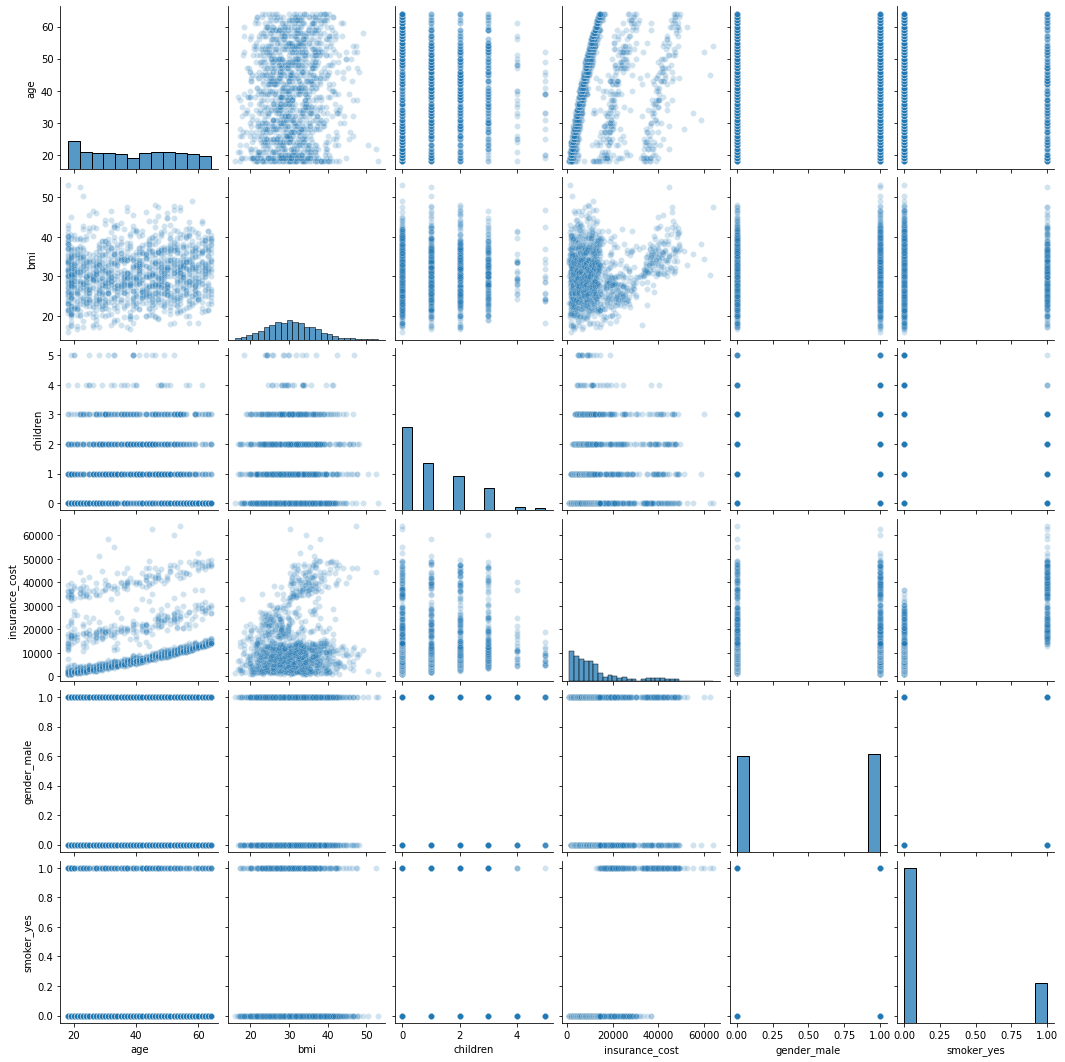

In [12]:
sns.pairplot(data=df, plot_kws={'alpha':0.2})
plt.show()

A few things to note when looking at this seaborn plot, for the features gender_male and smoker_yes, males and smokers are on the RHS (1), and females and non-smokers on the LHS (0)

# .

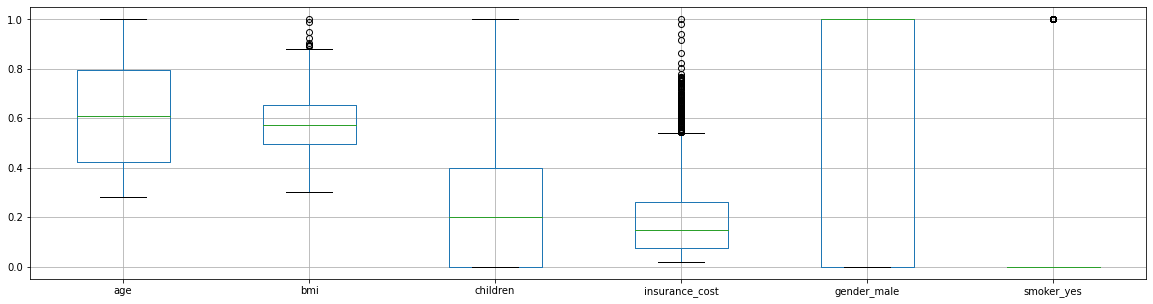

In [13]:
df._get_numeric_data().apply(lambda x: x / x.max()).boxplot(figsize=(20,5))
plt.show()

- normalized boxplots show `insurance_cost`, and `bmi` have outliers.


In [14]:
# One hot encode region
df = pd.get_dummies(df, columns=['region'],drop_first=True)

In [15]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['insurance_cost']]

# define column groups with same data preparation
names_outliers = ['bmi']
names_no_outliers = list(set(names_all) - set(names_outliers))

# We will use the following class in the preprocessing pipeline to put the 
# names of the columns back. We need this to easily apply the different preparation
# strategies to the two groups of columns. 

class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [16]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [17]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=10)


def define_pipe(model, preprocess_pipeline):
    return Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', model)])

def analyze_grid(pipe, param_grid, X_train, y_train):
    search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
    search.fit(X_train, y_train)

    print("Best CV score = %0.3f:" % search.best_score_)
    print("Best parameters: ", search.best_params_)

    # store the best params and best model for later use
    RF_best_params = search.best_params_
    RF_best_model = search.best_estimator_
    return RF_best_params, RF_best_model 

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

## Random Forest

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default), otherwise the whole dataset is used to build each tree.


## Linear Regressor

LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.


## Gradient Boosting Regressor

The 2 most important parameters of these estimators are n_estimators and learning_rate.
Gradient boosting is a type of machine learning boosting. It relies on the intuition that the best possible next model, when combined with previous models, minimizes the overall prediction error.
    
    If a small change in the prediction for a case causes a large drop in error,
     then next target outcome of the case is a high value. Predictions from the new model that are close to its targets will reduce the error.
     
    If a small change in the prediction for a case causes no change in error,
    then next target outcome of the case is zero. Changing this prediction does not decrease the error.


https://www.displayr.com/gradient-boosting-the-coolest-kid-on-the-machine-learning-block/

In [18]:
print("RandomForestRegressor")
pipe = define_pipe(RandomForestRegressor(n_estimators=10), preprocess_pipeline)

N_FEATURES_OPTIONS = [2, 4, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]
RF_best_params, RF_best_model = analyze_grid(pipe, param_grid, X_train, y_train)

# LINEAR_REGRESSOR
print("\n\nLINEAR_REGRESSOR")
pipe = define_pipe(LinearRegression(), preprocess_pipeline)
                       
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]
# store the best params and best model for later use
LR_best_params, LR_best_model = analyze_grid(pipe, param_grid, X_train, y_train)


#GradientBoostingRegressor
print( "\n\nGradientBoostingRegressor")
from sklearn.ensemble import GradientBoostingRegressor

pipe = define_pipe(GradientBoostingRegressor(), preprocess_pipeline)
                       
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS
}  
]
# store the best params and best model for later use
GBR_best_params, GBR_best_model = analyze_grid(pipe, param_grid, X_train, y_train)

RandomForestRegressor
Best CV score = 0.855:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}


LINEAR_REGRESSOR
Best CV score = 0.747:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'regresson__normalize': True}


GradientBoostingRegressor
Best CV score = 0.852:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11}


In [19]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [20]:
RF_mse, RF_mae, RF_r2    = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2    = evaluate_model(X_test, y_test, LR_best_model)
GBR_mse, GBR_mae, GBR_r2 = evaluate_model(X_test, y_test, GBR_best_model)

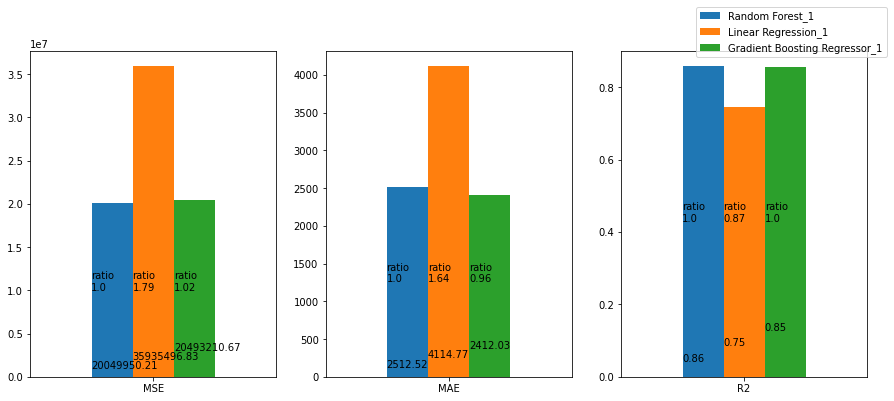

In [21]:
def annotate_bar(ax):
    # https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
    p_sum=0
    heights = [p.get_height() for p in ax.patches]
    step = heights[0]*0.05
    for p in ax.patches:
        p_sum += p.get_height()
    for p, i in zip(ax.patches, [1, 2, 3]):
        offset="\n"*ax.patches.index(p)
        ax.annotate(str(np.round(p.get_height(), 2)), (p.get_x()*1.01, i*step))
        ax.annotate(f'ratio\n{str(np.round(p.get_height()/heights[0], 2))}', (p.get_x()*1.01, ax.patches[0].get_height()*0.5))

df_mse_1 = pd.DataFrame({
        'Random Forest_1': RF_mse,
        'Linear Regression_1': LR_mse,
        'Gradient Boosting Regressor_1': GBR_mse},
    index=['MSE'])
df_mae_1 = pd.DataFrame({
        'Random Forest_1': RF_mae,
        'Linear Regression_1': LR_mae,
        'Gradient Boosting Regressor_1': GBR_mae},
    index=['MAE'])
df_r2__1 = pd.DataFrame({
        'Random Forest_1': RF_r2,
        'Linear Regression_1': LR_r2,
        'Gradient Boosting Regressor_1': GBR_r2},
    index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

df_mse_1.plot.bar(rot=0, ax=axes[0])
df_mae_1.plot.bar(rot=0, ax=axes[1])
df_r2__1.plot.bar(rot=0, ax=axes[2])

for ax in axes:
    annotate_bar(ax)
    if not ax==axes[-1]:
        ax.legend().remove()
    else:
        axes[2].legend(bbox_to_anchor=(1.1, 1.15))

    


# annotate_bar(axes[0])
# annotate_bar(axes[1])
# annotate_bar(axes[2])
# axes[0].legend().remove()
# axes[1].legend().remove()
# axes[2].legend(bbox_to_anchor=(1.1, 1.15))

plt.show()

The Linear regressor and the Gradient Boosting regressor perform very similarly.
The Random Forest has the worst performance by far, about a 1.7 : 1 ratio against the other two models in both MSE and MAE.

In [22]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

In [23]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

# task 2

In [24]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import LocallyLinearEmbedding

In [25]:
N_NEIGHBOURS_OPTIONS = [2, 5, 7, 15, 20]

In [26]:
pipe = define_pipe(LinearRegression(), preprocess_pipeline)


param_grid = [
    {
        'reduce_dim': [TruncatedSVD(n_components=6)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [LocallyLinearEmbedding(method='modified')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'reduce_dim__n_neighbors': N_NEIGHBOURS_OPTIONS
    }  
]


search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.725:
Best parameters:  {'reduce_dim': TruncatedSVD(n_components=6), 'reduce_dim__n_components': 6}


In [27]:
pipe = define_pipe(RandomForestRegressor(n_estimators=10), preprocess_pipeline)

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.733:
Best parameters:  {'reduce_dim': LocallyLinearEmbedding(method='modified', n_components=4, n_neighbors=20), 'reduce_dim__n_components': 4, 'reduce_dim__n_neighbors': 20}


In [28]:
pipe = define_pipe(GradientBoostingRegressor(), preprocess_pipeline)

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
GBR_best_params = search.best_params_
GBR_best_model = search.best_estimator_

Best CV score = 0.722:
Best parameters:  {'reduce_dim': TruncatedSVD(n_components=6), 'reduce_dim__n_components': 6}


In [29]:
RF_mse, RF_mae, RF_r2    = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2    = evaluate_model(X_test, y_test, LR_best_model)
GBR_mse, GBR_mae, GBR_r2 = evaluate_model(X_test, y_test, GBR_best_model)

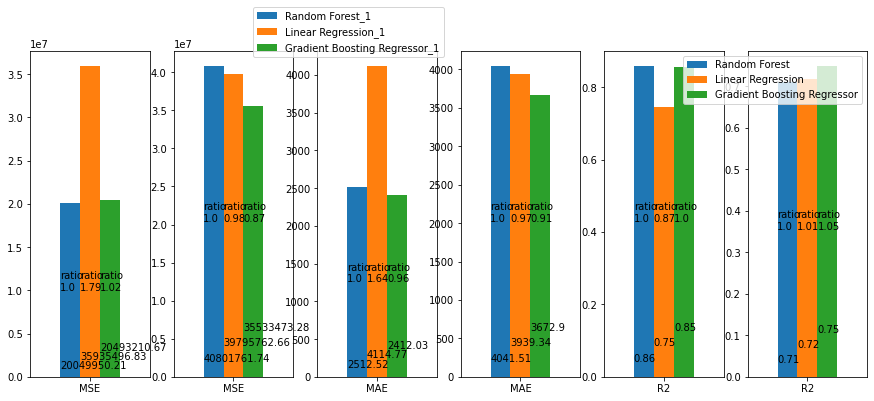

In [30]:
df_mse = pd.DataFrame({
        'Random Forest': RF_mse,
        'Linear Regression': LR_mse,
        'Gradient Boosting Regressor': GBR_mse},
    index=['MSE'])
df_mae = pd.DataFrame({
        'Random Forest': RF_mae,
        'Linear Regression': LR_mae,
        'Gradient Boosting Regressor': GBR_mae},
    index=['MAE'])
df_r2 = pd.DataFrame({
        'Random Forest': RF_r2,
        'Linear Regression': LR_r2,
        'Gradient Boosting Regressor': GBR_r2},
    index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15, 6))

df_mse_1.plot.bar(rot=0, ax=axes[0])
df_mse.plot.bar(rot=0, ax=axes[1])

df_mae_1.plot.bar(rot=0, ax=axes[2])
df_mae.plot.bar(rot=0, ax=axes[3])

df_r2__1.plot.bar(rot=0, ax=axes[4])
df_r2.plot.bar(rot=0, ax=axes[5])

for ax in axes:
    annotate_bar(ax)
    if not ax==axes[-1]:
        ax.legend().remove()
    else:
        axes[2].legend(bbox_to_anchor=(1.1, 1.15))

plt.show()

The results are quite different to task 1. 
The dimensionality reduction delivered by TruncatedSVC and LocallyLinearEmbedding did seem to improve the MSE and MAE of the Linear Regressor very slightly, but the performance of the Random Forest and GBR suffered significantly.


The best model configurations were as follows:

RandomForestRegressor
Best CV score = 0.855:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'regresson__max_depth': 4}